In [17]:
import numpy as np
import os
import threading
import operator
import pickle
import re
import pandas as pd


start_time = 1190146243
end_time = 1192994591

In [72]:
def get_lemma_distribution(file_name):
    lemmas=[]
    with open(file_name) as f:
        for line in f:
            url=line.strip().split(' ')[2]
            if url[7:9] != 'en':
                continue
            lemma=url[url.rfind('/')+1:]
            if ':' in lemma:
                continue
            lemmas.append(lemma)
    return lemmas


def count_lemma(dictionary, lemmas):
    for lemma in lemmas:
        if lemma not in dictionary:
            dictionary[lemma] = 1
        else:
            dictionary[lemma] += 1

            
def get_lemma_counter(num, nworkers = 4):
    data_root = "./data/only_lemma/"
    data_files = os.listdir(data_root)
    counter = {}

    threads = [None] * nworkers
    flags = [True] * nworkers
    
    if num > len(data_files):
        num = len(data_files)
    indices = np.random.choice(len(data_files), num)
    
    def target(index, flags, counter, filename):
        count_lemma(counter, get_lemma_distribution(filename))
        flags[index] = True
        
    j = 1
    
    for i in indices:
        index = 0
        while True:
            try:
                index = flags.index(True)
                flags[index] = False
                break
            except:
                continue
        print("Processing file {}".format(j))
        j += 1
        t = threading.Thread(target = target, args = [index, flags, counter, data_root + data_files[i]])
        threads[index] = t
        t.start()
        
    for thread in threads:
        if thread:
            thread.join()
    return counter

def get_url(entry):
    url = "https://en.wikipedia.org/wiki/{}".format(entry)
    return url
    
def sort_by_value(dictionary):
    sorted_dict = sorted(sort_by_value.items(), key=operator.itemgetter(1))
    return sorted_dict

def dump_data(data, output_name):
    with open(output_name, 'wb') as f:
        pickle.dump(data, f)

def load_data(input_name):
    with open(input_name, 'rb') as f:
        data = pickle.load(f)
    return data

def dump_word_frequency(data, output_dir, num = 2000):
    sorted_dict = sorted(counter.items(), key=operator.itemgetter(1), reverse=True)
    with open(output_dir+'hot_{}.csv'.format(num), 'w') as f:
        f.write("entry\tfrequency\n")
        for i in np.random.choice(100000, num):
            item = sorted_dict[i]
            if len(item[0]) == 0:
                continue
            f.write("{}\t{}\n".format(item[0], item[1]))
                
            

In [ ]:
#counter = get_lemma_counter(1000, nworkers = 50)
#dump_data(counter,"data/revisions/hot_words_all.pkl")

In [63]:
counter = load_data("data/revisions/hot_words_all.pkl")

In [73]:
#sorted_dict = sorted(counter.items(), key=operator.itemgetter(1))
dump_word_frequency(counter,"data/revisions/", num=10000)

In [137]:
import mwclient
from itertools import islice
import calendar
from urllib.parse import unquote
from urllib.parse import quote

site = mwclient.Site('en.wikipedia.org')

def get_revisions(title):
    page = site.pages[unquote(unquote(title))]
    revision = page.revisions(start=1192994591, end=1190146243, prop='ids|timestamp|flags|comment|user|size')
    return revision
def dump_revision(title, output_dir):
    revisions = get_revisions(title)
    error = False
    with open(output_dir + title + '.csv', 'w') as f:
        f.write("timestamp\trevid\tparentid\tuser\tsize\tcomment\n")
        for rev in revisions:
            if 'user' not in rev:
                rev['user'] = ''
            if 'comment' not in rev:
                rev['comment'] = ''
            if 'parentid' not in rev:
                rev['parentid'] = ''
            rev['comment'] = rev['comment'].replace("\"", " ").replace("\t", " ")
            try:
                f.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(calendar.timegm(rev['timestamp']), rev['parentid'], rev['revid'], rev['user'], rev['size'], rev['comment'].lstrip("\"")))
            except:
                import pdb
                pdb.set_trace()
                error = True
                break
                
    if error:
        print(title)
        os.remove(output_dir + title + '.csv')
        
def dump_revisions(titles, output_dir):
    finished = os.listdir(output_dir)
    j = 1
    for title in titles:
        #print("Processing Entry {}".format(j))
        j += 1
        if title+'.csv' not in finished:
            dump_revision(title, output_dir)

def clear_revisions(output_dir):
    finished = os.listdir(output_dir)
    for file in finished:
        num_line = 0
        with open(output_dir + file) as f:
            num_line = len(f.readlines())
        if num_line <= 1:
            os.remove(output_dir + file)
                
    


In [142]:
word_df = pd.read_csv("data/revisions/hot_10000.csv",delimiter='\t')
#clear_revisions('data/revisions/dump/')
words_list = set(word_df['entry'])
dump_revisions(words_list,'data/revisions/dump/')

In [92]:
def get_lemma_timestamps_from_file(file_name, entry_list, timestamps):
    with open(file_name) as f:
        for line in f:
            timestamp, url=line.strip().split(' ')[1:3]
            if url[7:9] != 'en':
                continue
            lemma=url[url.rfind('/')+1:]
            if lemma in entry_list:
                timestamps[lemma].append(timestamp)
        return timestamps

def get_lemma_timestamps(entry_list, nworkers = 10):
    timestamps = {}
    for entry in entry_list:
        timestamps[entry] = []
    data_root = "./data/only_lemma/"
    data_files = os.listdir(data_root)
    
    flags = [True] * nworkers
    threads = [None] * nworkers
    
    def target(index, flags, file_name, entry_list, timestamps):
        get_lemma_timestamps_from_file(file_name, entry_list, timestamps)
        flags[index] = True
    
    i = 0
    index = 0
    for file in data_files:
        while True:
            try:
                index = flags.index(True)
                flags[index] = False
                break
            except:
                continue
        i += 1
        print("Processing file {}".format(i))
        #target(timestamps, entry, data_root + file)
        t = threading.Thread(target = target, args = [index, flags, data_root + file, entry_list, timestamps])
        threads[index] = t
        t.start()
            
    for thread in threads:
        if thread:
            thread.join()
    return timestamps


In [ ]:
#time_stamps = get_lemma_timestamps(words_list)
#dump_data(time_stamps, "data/revisions/timestamps.pkl")

In [34]:
import pandas as pd

word_df = pd.read_csv("data/revisions/hot_10000.csv",delimiter='\t')
words_list = set(word_df['entry'])
access_timestamps = load_data("data/revisions/timestamps.pkl")

NameError: name 'load_data' is not defined

In [159]:
import pandas as pd
    
update_frequency = {}
access_frequency = {}

f = open("data/revisions/word-access-update-freq.csv", 'w')
f.write('entry\taccess\tupdate\n')
for word in words_list:
    try:
        revision = pd.read_csv("data/revisions/dump/{}.csv".format(word), delimiter='\t')
    except:
        import pdb
        pdb.set_trace()
        
    update_frequency[word] = len(revision)
    access_frequency[word] = len(access_timestamps[word])
    f.write("{}\t{}\t{}\n".format(word, len(access_timestamps[word]), len(revision)))
f.close()

  

In [140]:
update_frequency

{'It%27s_a_Wonderful_World_%28video_game%29': 0,
 'Bugsy_Malone': 6,
 'Bathymetry': 13,
 'April_27': 36,
 'Solar_system': 0,
 'Guitar_solo': 15,
 'Kazoo': 13,
 'Red_Cafe': 0,
 'The_Bell_Curve': 30,
 'Tourism': 71,
 'Mercury_Seven': 4,
 'Hell%27s_Kitchen_%28US%29': 0,
 'Salem_Witch_Trials': 0,
 'Pseudalopex_griseus': 0,
 'Peter_Fechter': 0,
 'The_Walt_Disney_Company': 173,
 'Eva_Marcille': 17,
 'Psycho_III': 3,
 'Nicholas_Negroponte': 2,
 'Snowmobile': 37,
 'Clitoral_hood_piercing': 0,
 'Ltd': 0,
 'Windsor_knot': 2,
 'Skin': 46,
 'Shirley_Henderson': 3,
 'Disposition': 0,
 'Gold_coin': 1,
 'Peggy_Lee': 17,
 'List_of_number-one_singles_from_the_1980s_%28UK%29': 0,
 'Quagmire': 0,
 'Ky%C5%ABsh%C5%AB': 0,
 'Pneumonia': 58,
 'Thomas_Hobbes': 97,
 'Trotsky': 0,
 'The_Holiday_%28film%29': 0,
 'The_Waste_Lands': 0,
 'Everlast': 0,
 'List_of_simpsons_episodes': 0,
 'Master_of_Puppets': 60,
 'Faramir': 14,
 'Nathan_Bedford_Forrest': 26,
 'Justice_(French_band)': 0,
 'Head_Start': 0,
 'National_S

In [33]:
import matplotlib.pyplot as plt
import numpy as np
    
def plot_time_series(word, access_timestamps, revision_dump_path):
    access_times = np.sort(np.array(access_timestamps[word],dtype=float)) - start_time
    plt.figure(0)
    plt.step(access_times, range(1, len(access_times)+1))
    plt.xlim((0,end_time-start_time))
    
    revision = pd.read_csv("{}{}.csv".format(revision_dump_path,word), delimiter='\t')
    update_times = (revision['timestamp'] - start_time)[::-1]
    plt.figure(1)
    plt.step(update_times, range(1, len(update_times)+1))
    plt.xlim((0,end_time-start_time))
    
    sizes = revision['size'][::-1]
    plt.figure(2)
    plt.step(update_times, sizes)
    plt.xlim((0,end_time-start_time))
    
    plt.show()

plot_time_series('Zoo', access_timestamps, 'data/revisions/dump/')   

NameError: name 'access_timestamps' is not defined

# Hypothesis 1: Access frequency with Update frequency 

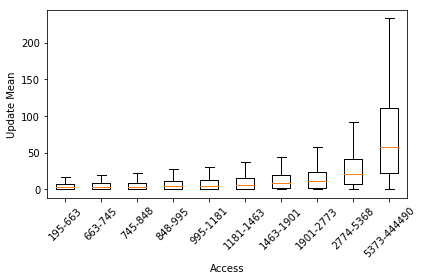

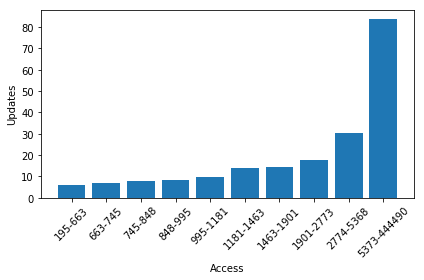

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

access_update = pd.read_csv("data/revisions/word-access-update-freq.csv", delimiter = "\t")

def update_sorted_by_access(word_df):
    tuples = word_df.apply(lambda row: (row['access'], row['update']), axis=1)
    return sorted(tuples, key = lambda x: x[0]) 
        
        
sort_list = update_sorted_by_access(access_update)

fig = plt.figure()
data = []
xlabels = []
for j in range(10):
    update = list(map(lambda x: x[1], sort_list[j * 1000: (j+1) * 1000]))
    access = list(map(lambda x: x[0], sort_list[j * 1000: (j+1) * 1000]))
    data.append(update)
    xlabels.append("{}-{}".format(min(access), max(access)))
plt.boxplot(data,0, '')
plt.xticks(range(1,11), xlabels)
plt.ylabel("Update")
plt.xlabel("Access")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.tight_layout()
plt.show()
fig.savefig("plots/access-update-boxplot.png", dpi=400)

fig = plt.figure()
data = []
xlabels = []
for j in range(10):
    update = list(map(lambda x: x[1], sort_list[j * 1000: (j+1) * 1000]))
    access = list(map(lambda x: x[0], sort_list[j * 1000: (j+1) * 1000]))
    data.append(np.mean(update))
    xlabels.append("{}-{}".format(min(access), max(access)))
plt.bar(range(10),data)
plt.xticks(range(10), xlabels)
plt.ylabel("Update Mean")
plt.xlabel("Access")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.tight_layout()
plt.show()
fig.savefig("plots/access-update-meanplot.png", dpi=400)


# Hypothesis 2: # vandalism with access frequency

# Hypothesis 3 : Deletion discovering times with frequency

# Hypothesis 4: # Recovery by ClueBot with access frequency